<a href="https://colab.research.google.com/github/sherryjasal/gpt-neox-20b-peft-bits-bytes/blob/main/Instruct_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install --no-cache-dir sentencepiece
#!pip install -q -U sentencepiece

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.8 MB/s eta 0

In [ ]:
from datasets import load_dataset


dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/databricks___json/databricks--databricks-dolly-15k-6e0f9ea7eaa0ee08/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Checking Stats of the Dataset Loaded

In [ ]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_seq_length(dataset_obj):

  # Initialize a list to store the sequence lengths
  sequence_lengths = []

  # list of indices that are too long
  too_long = []

  #loop over dataset and get sequence lengths
  for idx, example in enumerate(dataset_obj["train"]):
    sequence_lengths.append(len(example['instruction']) + len(example['context']) + len(example['response']))
    if sequence_lengths[idx] > 2200:
      too_long.append(idx)


  plt.hist(sequence_lengths, bins=30)
  plt.xlabel('Sequence_Length')
  plt.ylabel('Count')
  plt.title('Distribution of Text Sequence Lengths')
  plt.show()

  return too_long



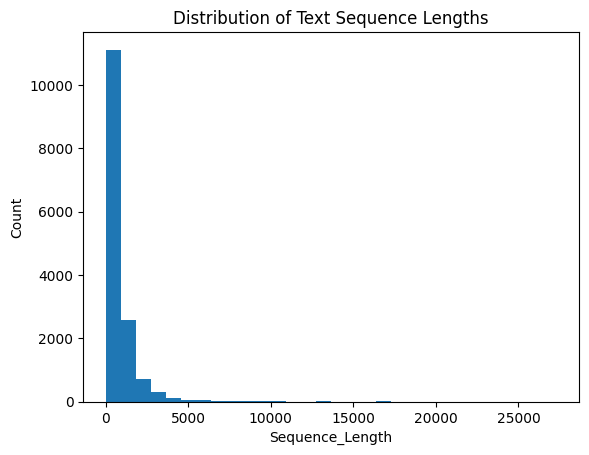

In [ ]:
indices_to_drop = plot_seq_length(dbricks_15k_dataset_base)

In [ ]:
len(indices_to_drop)

936

In [ ]:
dbricks_15k_dataset_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(indices_to_drop)
)

In [ ]:
dbricks_15k_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

In [ ]:
dbricks_15k_dataset_prepared = dbricks_15k_dataset_reduced.train_test_split(test_size = 0.1)

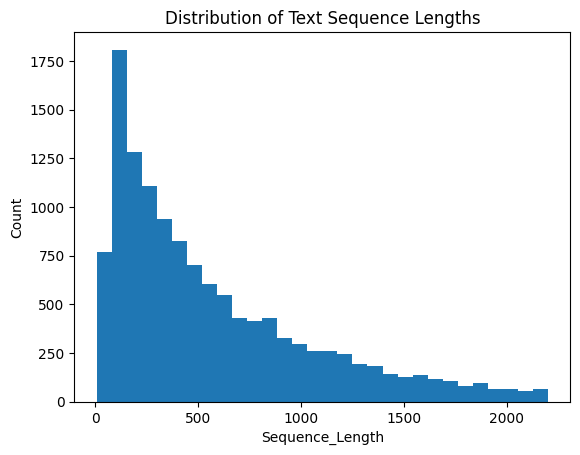

In [ ]:
indices_to_drop = plot_seq_length(dbricks_15k_dataset_prepared) #below graph represents the data below 2200 length

In [ ]:
dbricks_15k_dataset_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

Before we can begin training, we need to set up a few helper functions to ensure our dataset is parsed in the correct format and we save our PEFT adapters!

adapter-transformers is a library that extends 🤗 transformers by allowing to integrate, train and use Adapters and other efficient fine-tuning methods. Adapters are small learnt layers inserted within each layer of a pre-trained model.

In [ ]:
def formatting_func(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [ ]:
formatted_dataset = dbricks_15k_dataset_prepared.map(formatting_func)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [ ]:
formatted_dataset["train"][3]["text"]

"Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven this paragraph about the description of wakesurfing, what is needed to generate the wave?\n\n### Input: \nWakesurfing is a water sport in which a rider trails behind a boat, riding the boat's wake without being directly pulled by the boat. After getting up on the wake, typically by use of a tow rope, the wakesurfers will drop the rope, and ride the steep face below the wave's peak in a fashion reminiscent of surfing. Wakesurfers generally use special boards, designed specifically for wakes.\n\n### Response: \na boat"

Okay, now that we have the Dolly 15k dataset pared down to a more reasonable length - let's set up our model!

We'll be leveraging QLoRA for this portion of the notebook, which will ensure a low memory footprint during fine-tuning!
Paper

In [ ]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer


model_id = "openlm-research/open_llama_7b_700bt_preview"

qlora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('//172.28.0.1'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc483011

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
print(base_model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
from trl import SFTTrainer

supervised_finetuning_trainer = SFTTrainer(
    base_model,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        max_steps=5000,
        output_dir="./SFTOpenLM-Dolly15k",
        optim="paged_adamw_8bit",
        fp16=True,
    ),
    tokenizer=tokenizer,
    peft_config=qlora_config,
    dataset_text_field="text",
    max_seq_length=512
)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [ ]:
supervised_finetuning_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
500,0.794000
1000,0.167100
1500,0.122000
2000,0.096700
2500,0.072600
3000,0.052400
3500,0.037500
4000,0.025800
4500,0.018400
5000,0.013600


TrainOutput(global_step=5000, training_loss=0.1400117292404175, metrics={'train_runtime': 10081.181, 'train_samples_per_second': 1.984, 'train_steps_per_second': 0.496, 'total_flos': 2.0752770269184e+17, 'train_loss': 0.1400117292404175, 'epoch': 84.39})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
base_model.push_to_hub("thesherrycode/instruct-tune_llama_qlora_4bit", Private = True)
tokenizer.push_to_hub("thesherrycode/instruct-tune_llama_qlora_4bit")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:790 in push_to_hub             │
│                                                                                                  │
│    787 │   │   │   files_timestamps = self._get_files_timestamps(work_dir)                       │
│    788 │   │   │                                                                                 │
│    789 │   │   │   # Save all files.                                                             │
│ ❱  790 │   │   │   self.save_pretrained(work_dir, max_shard_size=max_shard_size)                 │
│    791 │   │   │                                                                                 │
│    792 │   │   │   return self._upload_modified_files(                                           │
│    793 │   │   │   │   work_dir,                                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1705 in save_pretrained   │
│                                                                                                  │
│   1702 │   │   │   )                                                                             │
│   1703 │   │                                                                                     │
│   1704 │   │   if getattr(self, "is_loaded_in_4bit", False):                                     │
│ ❱ 1705 │   │   │   raise NotImplementedError(                                                    │
│   1706 │   │   │   │   "You are calling `save_pretrained` on a 4-bit converted model. This is c  │
│   1707 │   │   │   )                                                                             │
│   1708                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NotImplementedError: You are calling `save_pretrained` on a 4-bit converted model. This is currently not supported

In [ ]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from transformers import AutoTokenizer

lora_config = LoraConfig.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("FourthBrainGenAI/FB-DLAI-Instruct-tune-v3")
model = AutoModelForCausalLM.from_pretrained(
    lora_config.base_model_name_or_path,
    quantization_config=bnb_config,
    device_map={"":0})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py:259 in                  │
│ hf_raise_for_status                                                                              │
│                                                                                                  │
│   256 │   </Tip>                                                                                 │
│   257 │   """                                                                                    │
│   258 │   try:                                                                                   │
│ ❱ 259 │   │   response.raise_for_status()                                                        │
│   260 │   except HTTPError as e:                                                                 │
│   261 │   │   error_code = response.headers.get("X-Error-Code")                                  │
│   262                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/requests/models.py:960 in raise_for_status               │
│                                                                                                  │
│   957 │   │   │   http_error_msg = u'%s Server Error: %s for url: %s' % (self.status_code, rea   │
│   958 │   │                                                                                      │
│   959 │   │   if http_error_msg:                                                                 │
│ ❱ 960 │   │   │   raise HTTPError(http_error_msg, response=self)                                 │
│   961 │                                                                                          │
│   962 │   def close(self):                                                                       │
│   963 │   │   """Releases the connection back to the pool. Once this method has been             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
HTTPError: 404 Client Error: Not Found for url: 
https://huggingface.co/FourthBrainGenAI/FB-DLAI-Instruct-tune-v3/resolve/main/adapter_config.json

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/peft/utils/config.py:111 in from_pretrained              │
│                                                                                                  │
│   108 │   │   │   config_file = os.path.join(path, CONFIG_NAME)                                  │
│   109 │   │   else:                                                                              │
│   110 │   │   │   try:                                                                           │
│ ❱ 111 │   │   │   │   config_file = hf_hub_download(                                             │
│   112 │   │   │   │   │   pretrained_model_name_or_path, CONFIG_NAME, subfolder=subfolder, **h   │
│   113 │   │   │   │   )                                                                          │
│   114 │   │   │   except Exception:                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:118 in _inner_fn    │
│                                                                                                  │
│   115 │   │   if check_use_auth_token:                                                           │
│   116 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   117 │   │                                